In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm
import random
from scipy.integrate import simps
from matplotlib.patches import Ellipse

### Use the test with samples drawn from the same distribution - compared to one bootstrap from itself each time

In [56]:
# Network generation --------------------------------------------------------
random.seed(10)
np.random.seed(10)

n = 1000  # number of nodes
K = 4   # number of node communities

# Community labels
tau = np.random.choice(K, n) # order tau would make the nice blocks
tau = np.sort(tau)
# print(tau)

# Generate stochastic block model (SBM) B matrix
"""Just one observation is required"""
B_list = []

B_list.append(np.array([[0.8, 0.1, 0.5, 0.3],
                        [0.4, 0.6, 0.9, 0.2],
                        [0.7, 0.2, 0.4, 0.8],
                        [0.3, 0.5, 0.6, 0.1]]))

In [57]:
# Generate adjacency matrix from the B matrix
As = np.zeros((n, n))
P_list = []

In [58]:
random.seed(100)
np.random.seed(100)

# Get probability matrix from B
P_t = np.column_stack(
    [B_list[0][tau, tau[i]] for i in range(n)])
P_list.append(P_t)

# Generate random graph from the P matrix
A_t = np.random.binomial(n=1, p=P_t)
# turn to integer from float
A_t = A_t.astype(int)
As = A_t

As = As.astype(int)
P = np.column_stack(P_list)

In [59]:
# Generate more samples from the same model with the same parameters (P matrix)
random.seed(100)
np.random.seed(100)

M=200
A_true_draws = []

for m in range(M):
    # Generate random graph from the P matrix
    A_t = np.random.binomial(n=1, p=P_t)
    # turn to integer from float
    A_t = A_t.astype(float)
    As = A_t

    As = As.astype(float)

    A_true_draws.append(As)

In [61]:
# for each of the true draws from the model, create a bootstrap and perform a test with Q permutations
random.seed(100)
np.random.seed(100)

p_vals = []
A_boots_list = []

for m in A_true_draws:
    p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=5)
    p_vals.append(p_val)
    A_boots_list.append(A_boots)

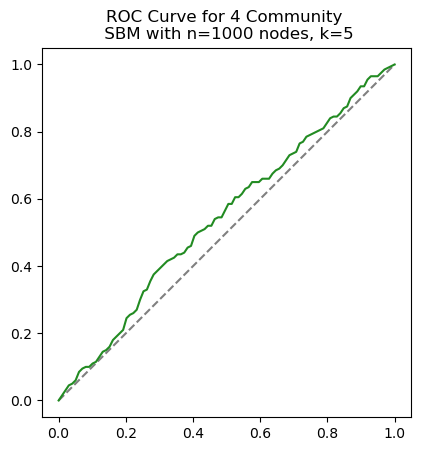

In [62]:
p_hat_list = p_vals
roc = []
alphas = []
for alpha in np.linspace(0, 1, 100):
    alphas.append(alpha)
    num_below_alpha = sum(p_hat_list < alpha)
    roc_point = num_below_alpha / len(p_hat_list)
    roc.append(roc_point)

# Get the power at the 5% significance level
power_significance = 0.05
power_idx = alphas.index(min(alphas, key=lambda x: abs(x - power_significance)))
power = roc[power_idx]


plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")
_ = plt.plot(alphas, roc, color='#228B22')

# Set title and aspect ratio
plt.title("ROC Curve for 4 Community \n SBM with n=1000 nodes, k=5")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig("4commSBM_knnBootstrap_k5_M200.png")

plt.show()

In [11]:
def compute_roc_and_areas(p_hat_list, significance_level=0.05):
    roc = []
    alphas = []

    for alpha in np.linspace(0, 1, 100):
        alphas.append(alpha)
        num_below_alpha = sum(p_hat_list < alpha)
        roc_point = num_below_alpha / len(p_hat_list)
        roc.append(roc_point)

    # Get the power at the significance level
    power_idx = alphas.index(min(alphas, key=lambda x: abs(x - significance_level)))
    power = roc[power_idx]

    # Calculate the area between ROC and y=x line
    def compute_area_above_below_curve(x, y):
        area_above = 0.0
        area_below = 0.0

        for i in range(1, len(x)):
            x0, x1 = x[i - 1], x[i]
            y0, y1 = y[i - 1], y[i]
            line0, line1 = x0, x1  # Since line y = x

            if y1 == y0:  # Vertical segment
                if y0 > x0:
                    area_above += (y0 - x0) * (x1 - x0)
                else:
                    area_below += (x0 - y0) * (x1 - x0)
                continue

            # Find intersection with y = x
            if (y0 >= x0 and y1 >= x1) or (y0 <= x0 and y1 <= x1):
                if y0 >= x0 and y1 >= x1:
                    area_above += 0.5 * (y0 + y1 - x0 - x1) * (x1 - x0)
                else:
                    area_below += 0.5 * (x0 + x1 - y0 - y1) * (x1 - x0)
            else:
                x_intersect = x0 + (x0 - y0) * (x1 - x0) / (y1 - y0)
                if y0 < x0:
                    area_below += 0.5 * (x0 - y0) * (x_intersect - x0)
                    area_above += 0.5 * (y1 - x1) * (x1 - x_intersect)
                else:
                    area_above += 0.5 * (y0 - x0) * (x_intersect - x0)
                    area_below += 0.5 * (x1 - y1) * (x1 - x_intersect)

        return area_above, area_below

    x = np.linspace(0, 1, 100)
    roc_interpolated = np.interp(x, alphas, roc)

    # Compute areas
    area_above, area_below = compute_area_above_below_curve(x, roc_interpolated)
    total_area = area_above + area_below

    return {
        "area_above": area_above,
        "area_below": area_below,
        "total_area": total_area
    }

In [12]:
compute_roc_and_areas(p_vals, significance_level=0.05)

{'area_above': 0.04167636470819818,
 'area_below': 2.030301999692891e-06,
 'total_area': 0.04167839501019788}

#### Some measures of variance estimation per node quality 

Here have M true draws, and select one true draw from which to sample B bootstrap matrices
I choose B=M-1, so each estimate of variance has the same number of networks to use. 

Variance estimation via MSE, Frobenius norm, spectral norm, e-value comparison

In [13]:
# make a list of M true draws and M-1 bootstrap samples from the first true draw

# all the true draws first
A_true_boots_list = A_true_draws

# then all the bootstrap samples of one matrix
m = A_true_draws[0]
# for i in range(M-1):
#     p_val, A_boots = create_single_kNN_bootstrap(m, d=d, Q=1000, n_neighbors=5)
#     A_true_boots_list.append(A_boots)

A_true_boots_list = knn_bootstraps(m, d=d, B=M-1, embedding_function=UASE, sparse_matrix=True)

len(A_true_boots_list)

Embedding the graph...
Estimating the P matrix...


/Users/madjl/envs/jupyter/lib/python3.10/site-packages/numba/typed/typeddict.py:34: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.
  d[key] = value


Generating bootstraps...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199/199 [00:23<00:00,  8.39it/s]


199

In [14]:
np.sum(m)

470021.0

In [15]:
# embed into d=4 dimensions (as rank(P) = 4)
yhat_A_true_boots = UASE(A_true_boots_list, d=4, sparse_matrix=False)

ValueError: `A` must be of floating or complex floating data type.

In [ ]:
# embed into d=4 dimensions (as rank(P) = 4)

# from scipy import sparse

# for i in range(0, len(A_true_boots_list)):
#     A_true_boots_list[i] = sparse.csr_matrix(A_true_boots_list[i])

yhat_A_true_boots = UASE(A_true_boots_list, d=4, sparse_matrix=True)

In [ ]:
yadf = pd.DataFrame(yhat_A_true_boots)

# rename the columns - this is called a list comprehension
yadf.columns = ["Dimension_{}".format(i+1) for i in range(yadf.shape[1])] 

# repeats tau list the len of A_true_boots_list times
yadf["tau"] = (tau.tolist())*(len(A_true_boots_list))

# add column for the matrix it is
yadf["Matrix"] = np.repeat(range(len(A_true_boots_list)), n)

# add a column for the type of data
yadf['TrueSample'] = [1]*n*M + [0]*n*(M-1)

# give nodes a number
yadf["NodeNumber"] = np.tile(range(n), (2*M)-1)

In [ ]:
"""Plot for a specific node"""

node_number = 0

# Plot the points and covariance matrix
fig, axes = plt.subplots(1, 2, facecolor='white', figsize=(16, 6))

data_true = yadf[(yadf["TrueSample"] == 1) & (yadf["NodeNumber"] == node_number)].iloc[:, 0:d].to_numpy()
data_boots = yadf[((yadf["TrueSample"] == 0) & (yadf["NodeNumber"] == node_number) ) | ((yadf['Matrix'] == 0) & (yadf["NodeNumber"] == node_number))].iloc[:, 0:d].to_numpy()

# Calculate the mean and covariance considering all d dimensions
mean_d_dim = np.mean(data_true, axis=0)
cov_d_dim = np.cov(data_true, rowvar=False)
mean_boots_d_dim = np.mean(data_boots, axis=0)
cov_boots_d_dim = np.cov(data_boots, rowvar=False)

# Eigen decomposition of the covariance matrix (considering all d dimensions)
eigenvalues, eigenvectors = np.linalg.eigh(cov_d_dim)
order = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[order]
eigenvectors = eigenvectors[:, order]

eigenvalues_boots, eigenvectors_boots = np.linalg.eigh(cov_boots_d_dim)
order_boots = eigenvalues_boots.argsort()[::-1]
eigenvalues_boots = eigenvalues_boots[order_boots]
eigenvectors_boots = eigenvectors_boots[:, order_boots]

def plot_ellipse(ax, mean, cov, color):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues[:2])
    ellipse = Ellipse(mean, width, height, angle, edgecolor=color, facecolor='none', lw=2, label=f'Covariance Ellipse ({color})')
    ax.add_patch(ellipse)

# Plotting the first 2 dimensions
ax = axes[0]
data_2d = data_true[:, 0:2]
data_boots_2d = data_boots[:, 0:2]
ax.scatter(data_2d[:, 0], data_2d[:, 1], alpha=0.5, label='Data Points')
ax.scatter(data_boots_2d[:, 0], data_boots_2d[:, 1], alpha=0.5, label='Bootstrap Samples', color='g')
plot_ellipse(ax, mean_d_dim[:2], cov_d_dim[:2, :2], 'blue')
plot_ellipse(ax, mean_boots_d_dim[:2], cov_boots_d_dim[:2, :2], 'green')
ax.set_title(f'Scatter Plot and Covariance Ellipse for Dimensions 1 and 2 of Node {node_number}')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.legend()

# Plotting the 3rd and 4th dimensions
ax = axes[1]
data_3d = data_true[:, 2:4]
data_boots_3d = data_boots[:, 2:4]
ax.scatter(data_3d[:, 0], data_3d[:, 1], alpha=0.5, label='Data Points')
ax.scatter(data_boots_3d[:, 0], data_boots_3d[:, 1], alpha=0.5, label='Bootstrap Samples', color='g')
plot_ellipse(ax, mean_d_dim[2:4], cov_d_dim[2:4, 2:4], 'blue')
plot_ellipse(ax, mean_boots_d_dim[2:4], cov_boots_d_dim[2:4, 2:4], 'green')
ax.set_title(f'Scatter Plot and Covariance Ellipse for Dimensions 3 and 4 of Node {node_number}')
ax.set_xlabel('Dimension 3')
ax.set_ylabel('Dimension 4')
ax.legend()

plt.show()


In [ ]:
MSE_cov_knn_list = []   
MSE_mean_knn_list = []

for i in range(M):
    node_number = i

    data_true = yadf[(yadf["TrueSample"] == 1) & (yadf["NodeNumber"] == node_number)].iloc[:, 0:d].to_numpy()
    data_boots = yadf[((yadf["TrueSample"] == 0) & (yadf["NodeNumber"] == node_number) ) | ((yadf['Matrix'] == 0) & (yadf["NodeNumber"] == node_number))].iloc[:, 0:d].to_numpy()

    # Calculate the mean and covariance considering all d dimensions
    mean_d_dim = np.mean(data_true, axis=0)
    cov_d_dim = np.cov(data_true, rowvar=False)
    mean_boots_d_dim = np.mean(data_boots, axis=0)
    cov_boots_d_dim = np.cov(data_boots, rowvar=False)

    # calculate the MSE between cov_d_dim and cov_boots_d_dim
    MSE = np.mean((cov_d_dim - cov_boots_d_dim)**2)
    MSE_cov_knn_list.append(MSE)
    # calculate the MSE between mean_d_dim and mean_boots_d_dim
    MSE = np.mean((mean_d_dim - mean_boots_d_dim)**2)
    MSE_mean_knn_list.append(MSE)

In [ ]:
# Create the figure and the first y-axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot MSE for Mean Vector
color = 'tab:blue'
ax1.set_xlabel('Node Number')
ax1.set_ylabel('MSE Mean Vector', color=color)
ax1.plot(MSE_mean_knn_list, color=color, label='MSE Mean Vector')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot MSE for Covariance Matrix
color = 'tab:red'
ax2.set_ylabel('MSE Covariance Matrix', color=color)
ax2.plot(MSE_cov_knn_list, color=color, label='MSE Covariance Matrix')
ax2.tick_params(axis='y', labelcolor=color)

# Title
plt.title('MSE between True Data and Bootstrap Samples')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# Show plot
plt.show()

In [ ]:
print(f"Average MSE for Mean Vector: {np.mean(MSE_mean_knn_list)}, Average MSE for Covariance Matrix: {np.mean(MSE_cov_knn_list)}")

# XXXXX DJL

In [25]:
def get_P_from_B(B,n):
# Get probability matrix from B
    K = B.shape[0]  # number of node communities
    # Community labels
    tau = np.random.choice(K, n) # order tau would make the nice blocks
    tau = np.sort(tau)
    P_t = np.column_stack(
        [B_list[0][tau, tau[i]] for i in range(n)])
    return P_t

In [ ]:
A_true_draws = []

for m in range(M):
    # Generate random graph from the P matrix
    A_t = np.random.binomial(n=1, p=P_t)
    # turn to integer from float
    A_t = A_t.astype(float)
    As = A_t

    As = As.astype(float)

    A_true_draws.append(As)

In [86]:
import math
# Generate more samples from the same model with the same parameters (P matrix)
random.seed(100)
np.random.seed(100)

M=50
Nlist=[10,50,100,200,500,1000,2000]
n_neighbors=[math.floor(x/5) for x in Nlist]
P_growing_draws = []
A_growing_draws = []

for n in range(len(Nlist)):
    P_growing_draws.append(get_P_from_B(B,Nlist[n]))
    print(P_growing_draws[n].shape)
    A_growing_draws.append([])
    for m in range(M):
        # Generate random graph from the P matrix
        A_t = np.random.binomial(n=1, p=P_growing_draws[n])
        # turn to integer from float
        A_t = A_t.astype(float)
        As = A_t
        As = As.astype(float)
        A_growing_draws[n].append(As)

(10, 10)
(50, 50)
(100, 100)
(200, 200)
(500, 500)
(1000, 1000)
(2000, 2000)


In [164]:
n_neighbors=[math.floor(math.sqrt(x)) for x in Nlist]
print(n_neighbors)

[3, 7, 10, 14, 22, 31, 44]


In [87]:
m=A_growing_draws[0][0]
p_val, A_boots = create_single_parametric_bootstrap_cropPto0_1range(m,d=d,Q=500)
A_true_boots_list = knn_bootstraps(m, d=d, B=M-1, embedding_function=UASE, sparse_matrix=True)


/Users/madjl/code/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:109: UserWarning: P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.
  warnings.warn("P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.")


In [155]:
print(Nlist)

[10, 50, 100, 200, 500, 1000, 2000]


In [ ]:
=[5,5

In [166]:

A_growing_boots_listKNN = []
A_growing_boots_listXYT = []
p_growing_vals_XYT = []
p_growing_vals_KNN = []
for n in range(len(Nlist)):
    p_growing_vals_XYT.append([])
    p_growing_vals_KNN.append([])
    A_growing_boots_listXYT.append([])
    A_growing_boots_listKNN.append([])
    for m in range(M):
        p_val, A_boots = create_single_parametric_bootstrap_cropPto0_1range(A_growing_draws[n][m],d=d,Q=200)
        p_growing_vals_XYT[n].append(p_val)
        A_growing_boots_listXYT[n].append(A_boots)
        p_valk, A_bootsk = create_single_kNN_bootstrap(A_growing_draws[n][m], d=d, Q=200, n_neighbors=n_neighbors[n])
        p_growing_vals_KNN[n].append(p_valk)
        A_growing_boots_listKNN[n].append(A_bootsk)


/Users/madjl/code/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:109: UserWarning: P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.
  warnings.warn("P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.")
/Users/madjl/code/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:109: UserWarning: P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.
  warnings.warn("P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.")
/Users/madjl/code/ResamplingAdjacencyMatrices/functions_for_bootstrap.py:109: UserWarning: P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.
  warnings.warn("P_hat contains values outside of [0,1]. The values outside this range will be clipped to lie in the range.")
/Users/madjl/code/Resampling

In [167]:
alphasKNN=[]
alphasXYT=[]
powersKNN=[]
powersXYT=[]
rocKNN=[]
rocXYT=[]
for n in range(len(Nlist)):
    alphasKNN.append([])
    alphasXYT.append([])
    rocKNN.append([])
    rocXYT.append([])
    p_hat_list = p_growing_vals_XYT[n]
    for alpha in np.linspace(0, 1, 100):
        alphasXYT[n].append(alpha)
        num_below_alpha = sum(p_hat_list < alpha)
        roc_point = num_below_alpha / len(p_hat_list)
        rocXYT[n].append(roc_point)
    # Get the power at the 5% significance level
    power_significance = 0.05
    power_idx = alphasXYT[n].index(min(alphasXYT[n], key=lambda x: abs(x - power_significance)))
    power = rocXYT[n][power_idx]
    powersXYT.append(power)
    
    p_hat_list = p_growing_vals_KNN[n]
    for alpha in np.linspace(0, 1, 100):
        alphasKNN[n].append(alpha)
        num_below_alpha = sum(p_hat_list < alpha)
        roc_point = num_below_alpha / len(p_hat_list)
        rocKNN[n].append(roc_point)
    # Get the power at the 5% significance level
    power_significance = 0.05
    power_idx = alphasKNN[n].index(min(alphasKNN[n], key=lambda x: abs(x - power_significance)))
    power = rocKNN[n][power_idx]
    powersKNN.append(power)

In [168]:
print(powersKNN)
print(powersXYT)


[0.04, 0.06, 0.0, 0.0, 0.0, 0.0, 0.2]
[0.52, 0.52, 0.54, 0.5, 0.56, 0.56, 0.7]


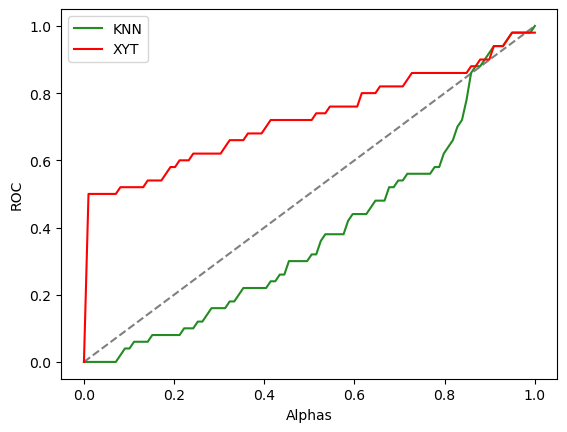

In [170]:
n=3
# Plotting two dashed grey lines
plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), linestyle="--", c="grey")

# Plotting the first line in green
plt.plot(alphasKNN[n], rocKNN[n], color='#228B22', label='KNN')

# Plotting the second line in red
plt.plot(alphasXYT[n], rocXYT[n], color='#FF0000', label='XYT')

# Adding labels and legend
plt.xlabel('Alphas')
plt.ylabel('ROC')
plt.legend()

# Display the plot
plt.show()

In [171]:
print(powersKNN)
print(powersXYT)

[0.04, 0.06, 0.0, 0.0, 0.0, 0.0, 0.2]
[0.52, 0.52, 0.54, 0.5, 0.56, 0.56, 0.7]


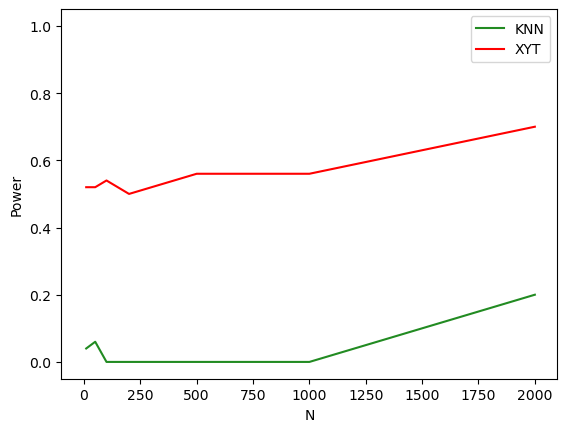

In [173]:
n=3
# Plotting two dashed grey lines
plt.plot(np.linspace(0, 1, 2), np.linspace(1, 1, 2), linestyle="--", c="grey")

# Plotting the first line in green
plt.plot(Nlist, powersKNN, color='#228B22', label='KNN')

# Plotting the second line in red
plt.plot(Nlist, powersXYT, color='#FF0000', label='XYT')

# Adding labels and legend
plt.xlabel('N')
plt.ylabel('Power')
plt.legend()

# Display the plot
plt.show()